In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv('/content/drive/MyDrive/air/data_f.csv')
data

,x-axis,y-axis,z-axis,number
0,1.569064,1.019892,10.355822,0
1,-1.216025,-1.647517,14.082349,0
2,-2.588956,-3.020448,14.239256,0
3,-4.354153,-3.491167,15.063014,0
4,-4.040340,-3.491167,14.278482,0
...,...,...,...,...
530975,-4.785645,1.686744,7.845320,9
530976,-4.824872,1.686744,7.806093,9
530977,-4.824872,1.647517,7.923773,9
530978,-4.785645,1.647517,7.806093,9


In [ ]:
df=pd.DataFrame(data)
df

,x-axis,y-axis,z-axis,number
0,1.569064,1.019892,10.355822,0
1,-1.216025,-1.647517,14.082349,0
2,-2.588956,-3.020448,14.239256,0
3,-4.354153,-3.491167,15.063014,0
4,-4.040340,-3.491167,14.278482,0
...,...,...,...,...
530975,-4.785645,1.686744,7.845320,9
530976,-4.824872,1.686744,7.806093,9
530977,-4.824872,1.647517,7.923773,9
530978,-4.785645,1.647517,7.806093,9


In [ ]:
df['number'].value_counts()

5    53278
4    53245
8    53225
3    53208
9    53198
7    53067
6    53024
2    52995
0    52970
1    52770
Name: number, dtype: int64

## Standardized data

In [ ]:
from sklearn.preprocessing import StandardScaler
x=df[['x-axis','y-axis','z-axis']]
y=df['number']
scaler=StandardScaler()
X=scaler.fit_transform(x)

In [ ]:
scaled_X=pd.DataFrame(data=X,columns=['x-axis','y-axis','z-axis'])
scaled_X['number']=y.values

scaled_X

,x-axis,y-axis,z-axis,number
0,1.095757,0.014281,0.582334,0
1,0.062762,-0.628696,1.685685,0
2,-0.446461,-0.959640,1.732142,0
3,-1.101176,-1.073106,1.976040,0
4,-0.984782,-1.073106,1.743756,0
...,...,...,...,...
530975,-1.261218,0.175025,-0.160976,9
530976,-1.275767,0.175025,-0.172590,9
530977,-1.275767,0.165569,-0.137747,9
530978,-1.261218,0.165569,-0.172590,9


In [ ]:
df

,x-axis,y-axis,z-axis,number
0,1.569064,1.019892,10.355822,0
1,-1.216025,-1.647517,14.082349,0
2,-2.588956,-3.020448,14.239256,0
3,-4.354153,-3.491167,15.063014,0
4,-4.040340,-3.491167,14.278482,0
...,...,...,...,...
530975,-4.785645,1.686744,7.845320,9
530976,-4.824872,1.686744,7.806093,9
530977,-4.824872,1.647517,7.923773,9
530978,-4.785645,1.647517,7.806093,9


In [ ]:
import scipy.stats as stats

In [ ]:
fs=20
frame_size=fs*10
hop_size=fs*2

In [ ]:
def get_frames(df,frame_size,hop_size):
    N_FEATURES=3
    
    frames=[]
    lables=[]
    for i in range(0,len(df)-frame_size,hop_size):
        x=df['x-axis'].values[i: i+frame_size]
        y=df['y-axis'].values[i: i+frame_size]
        z=df['z-axis'].values[i: i+frame_size]   
        
        lable = stats.mode(df['number'][i: i+frame_size])[0][0]
        frames.append([x,y,z])
        lables.append(lable)
    frames=np.asarray(frames).reshape(-1,frame_size,N_FEATURES)
    lables=np.asarray(lables)
    
    return frames ,lables

In [ ]:
X_x,Y_y=get_frames(df,frame_size,hop_size)

In [ ]:
X_x.shape , Y_y.shape

((13270, 200, 3), (13270,))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
X_train , X_test, y_train, y_test = train_test_split(X_x,Y_y,test_size=0.2,random_state=0,stratify=Y_y)

In [ ]:
X_test.shape,X_train.shape,y_test.shape,y_train.shape

((2654, 200, 3), (10616, 200, 3), (2654,), (10616,))

In [ ]:
X_test= X_test.reshape(2654, 200, 3, 1)
X_train=X_train.reshape(10616, 200, 3, 1)

In [ ]:
X_test.shape,X_train.shape

((2654, 200, 3, 1), (10616, 200, 3, 1))

In [ ]:
X_test

array([[[[-0.6276256],
         [-0.8629852],
         [-0.8629852]],

        [[-0.9414384],
         [-1.1375714],
         [-0.8629852]],

        [[-0.7060788],
         [-0.196133 ],
         [-0.0784532]],

        ...,

        [[ 8.9828914],
         [ 8.7475318],
         [ 8.3944924]],

        [[ 8.237586 ],
         [ 7.649187 ],
         [ 7.3746008]],

        [[ 7.1392412],
         [ 6.6292954],
         [ 5.9624432]]],


       [[[ 0.0392266],
         [-0.0392266],
         [-0.0392266]],

        [[-0.0392266],
         [-0.0392266],
         [-0.0784532]],

        [[-0.196133 ],
         [-0.2353596],
         [ 0.       ]],

        ...,

        [[ 9.0613446],
         [ 8.6690786],
         [ 8.1591328]],

        [[ 7.4922806],
         [ 6.472389 ],
         [ 5.491724 ]],

        [[ 5.099458 ],
         [ 4.7856452],
         [ 4.4326058]]],


       [[[-3.8834334],
         [-3.92266  ],
         [-3.92266  ]],

        [[-4.0011132],
         [-4.118793 ],

### 2D CNN Model

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D ,Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam , RMSprop

In [ ]:
model=Sequential()
model.add(Conv2D(16, (2,2), activation = 'relu', input_shape= X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2,2), activation = 'relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=1, validation_data= (X_test, y_test),verbose=1)

Epoch 1/50
10616/10616 [==============================] - 90s 8ms/step - loss: 2.0072 - accuracy: 0.2308 - val_loss: 1.5865 - val_accuracy: 0.4141
Epoch 2/50
10616/10616 [==============================] - 85s 8ms/step - loss: 1.7402 - accuracy: 0.3189 - val_loss: 1.4016 - val_accuracy: 0.5430
Epoch 3/50
10616/10616 [==============================] - 88s 8ms/step - loss: 1.6061 - accuracy: 0.3803 - val_loss: 1.1132 - val_accuracy: 0.6127
Epoch 4/50
10616/10616 [==============================] - 81s 8ms/step - loss: 1.5720 - accuracy: 0.3945 - val_loss: 1.2187 - val_accuracy: 0.5475
Epoch 5/50
10616/10616 [==============================] - 83s 8ms/step - loss: 1.5329 - accuracy: 0.4121 - val_loss: 1.1240 - val_accuracy: 0.6402
Epoch 6/50
10616/10616 [==============================] - 87s 8ms/step - loss: 1.5104 - accuracy: 0.4336 - val_loss: 1.1016 - val_accuracy: 0.5430
Epoch 7/50
10616/10616 [==============================] - 84s 8ms/step - loss: 1.4719 - accuracy: 0.4362 - val_loss: 1

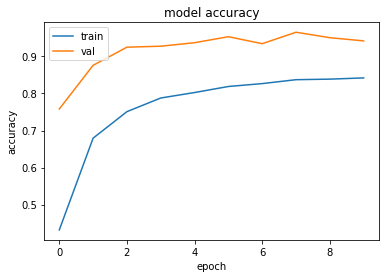

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/air/model.h5',save_format='h5')
# !ls /content/drive/MyDrive/air/

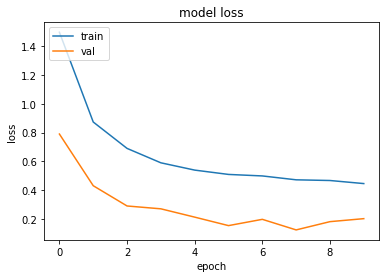

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
p=model.predict(X_test[:1])
a=max((p.max(axis=0)))
print(p)
s=np.where(p==a)#index of the max 
#print(X_test[:1])
print(s)

1/1 [==============================] - 0s 84ms/step
[[9.7549590e-04 3.2174620e-22 1.1713723e-05 6.4006841e-01 3.6573317e-06
  3.5881409e-01 1.0419817e-04 5.0310303e-09 2.2350543e-05 2.7485603e-09]]
(array([0]), array([3]))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 199, 2, 16)        80        
                                                                 
 dropout_6 (Dropout)         (None, 199, 2, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 198, 1, 32)        2080      
                                                                 
 dropout_7 (Dropout)         (None, 198, 1, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 6336)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                405568    
                                                                 
 dropout_8 (Dropout)         (None, 64)               

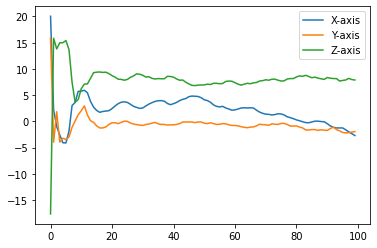

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 1][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 1][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 1][:100], label='Z-axis')
plt.legend()

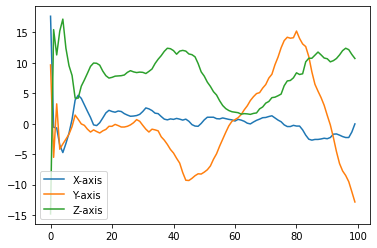

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 2][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 2][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 2][:100], label='Z-axis')
plt.legend()

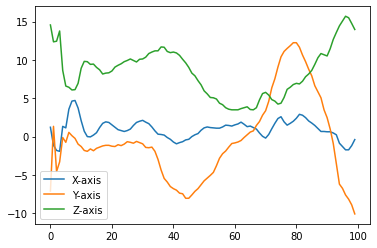

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 3][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 3][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 3][:100], label='Z-axis')
plt.legend()

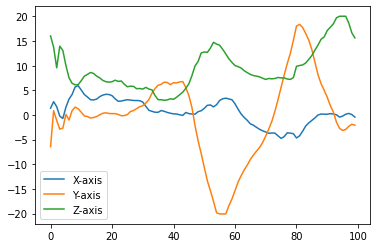

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 4][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 4][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 4][:100], label='Z-axis')
plt.legend()

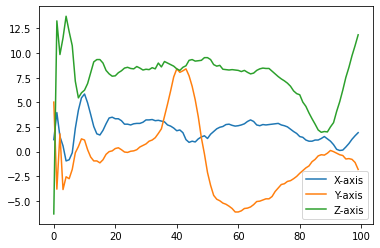

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 5][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 5][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 5][:100], label='Z-axis')
plt.legend()

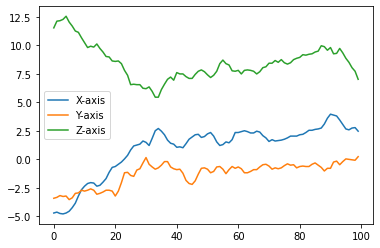

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 6][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 6][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 6][:100], label='Z-axis')
plt.legend()

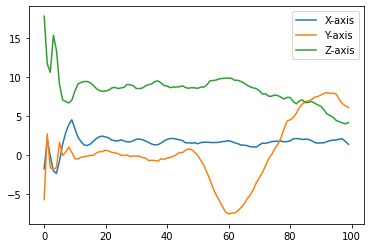

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 7][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 7][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 7][:100], label='Z-axis')
plt.legend()

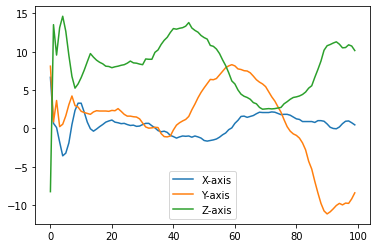

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 8][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 8][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 8][:100], label='Z-axis')
plt.legend()

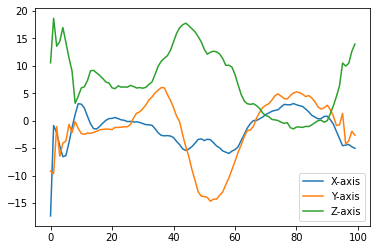

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 9][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 9][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 9][:100], label='Z-axis')
plt.legend()

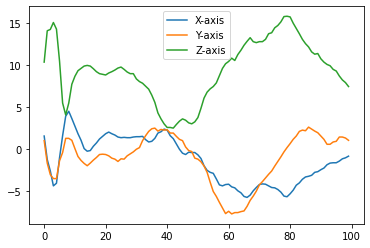

In [ ]:

plt.plot(np.arange(0,100),df['x-axis'][df['number'] == 0][:100], label='X-axis')
plt.plot(np.arange (0,100),df['y-axis'][df['number'] == 0][:100], label='Y-axis')
plt.plot(np.arange (0,100),df['z-axis'][df['number'] == 0][:100], label='Z-axis')
plt.legend()